In [1]:
import transformers
import numpy as np
from tqdm.auto import tqdm
import glob
from datasets import load_dataset, load_metric, Dataset, Audio
from transformers import AutoModel, AutoProcessor
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'


/Applications/miniconda3/envs/py3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading the TIMIT dataset
timit = load_dataset('timit_asr', data_dir='timit')


/Applications/miniconda3/envs/py3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for timit_asr contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/timit_asr
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
import os
import re
import spacy

nlp = spacy.load("en_core_web_sm")

In [4]:
# Code for generating and saving phoneme representation (hidden state
# activations of the speech models)

def saving_word_identities(model_name = "facebook/wav2vec2-base",
                                   overwrite = False,
                                   split = 'test',
                                   save_dir = '/Users/vincefan/Documents/Meow/LOT/results/',
                                   return_pos = True):

  model_savename = model_name.replace('/','-')
  savename = os.path.join(save_dir, f'{model_savename}_timit-{split}_phoneme-representations.pt')
  # Load the pre-trained wav2vec2 model and processor
  model = AutoModel.from_pretrained(model_name).to(device)
  # processor = AutoProcessor.from_pretrained(model_name)
  # Define a function to extract phoneme-level representations
  def extract_word_identities(example):
    word_identities, labels =[], []
    audio_input = example['audio']['array']
    word_info = example["word_detail"]
    doc = nlp(" ".join(example["word_detail"]["utterance"]))
    pos = [w.pos_ for w in doc]
    dep = [w.dep_ for w in doc]
    if return_pos: 
       word_info = list(zip(word_info['start'], word_info['stop'], pos))
    else:
       word_info = list(zip(word_info['start'], word_info['stop'], dep))
    samples_in_frame = example['audio']['sampling_rate']*0.02
    # Tokenize the audio and get hidden states from the model
    with torch.no_grad():
        inputs = torch.from_numpy(audio_input).unsqueeze(0).to(torch.float32)
        hidden_states = torch.stack(model(inputs.to(device), output_hidden_states = True).hidden_states).detach()
        # inputs = processor(audio_input, return_tensors="pt")
        # hidden_states = torch.stack(model(**inputs.to(device), output_hidden_states = True).hidden_states).detach()

    # Extract individual vectors for each phoneme
    for start_sample, stop_sample, word_ident in word_info:
        start_frame, stop_frame = int(start_sample/samples_in_frame), int(stop_sample/samples_in_frame)
        stop_frame = int(start_frame + 1) if start_frame == stop_frame else stop_frame
        word_vectors = torch.mean(hidden_states[:,:, start_frame:stop_frame, :], dim = -2)
        word_identities.append(word_vectors)
        labels.append(word_ident)
    return torch.stack(word_identities), np.array(labels)
  # Load the phoneme representations if they exist already
  # Generate and save them if they do not exist
  if os.path.isfile(savename) and not overwrite:
    print(f"{savename} exists already! loading it instead of generating a new one")
    word_identities = torch.load(savename)
  else:
    word_identities = [extract_word_identities(x) for x in tqdm(timit[split])]
    torch.save(word_identities,  savename)
  return word_identities


In [5]:
# Code for processing phoneme representation (hidden state activations of the
# speech models) into input for a Classifier
def generating_classifier_input(word_identities, overwrite = False):
  word_vectors, labels = zip(*word_identities)
  word_vectors = torch.cat(word_vectors).cpu()
  labels = np.concatenate(labels)

  mask_remove_silence = (labels != 'h#')

  word_vectors = word_vectors[mask_remove_silence]
  labels = labels[mask_remove_silence]

  classifier_input = {'input': word_vectors,
                      'labels': labels}
  return classifier_input

In [6]:
# Code for running phoneme classification in PyTorch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import gc


# Define a simple classifier in PyTorch
class WordClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(WordClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

def classification(classifier_input):
  # With the sklearn's train_test_split function, we generate 80 percent
  # training data for our classifier and 20 percent validation data
  train_features, val_features, train_labels, val_labels = train_test_split(
    classifier_input['input'].squeeze(),
    classifier_input['labels'],
    test_size=0.2,
    random_state=42)

  # Then we use a LabelEncoder to process the phoneme labels that are strings
  # into a tensor so our classifier can take them as inputs
  le = preprocessing.LabelEncoder()
  train_targets = torch.as_tensor(le.fit_transform(train_labels))
  val_targets = torch.as_tensor(le.transform(val_labels))

  layers = train_features.shape[1] # How many layers there are in the model
  num_classes = len(set(val_labels) | set(train_labels)) # How many unique phonemes exists in our dataset
  all_results = []

  # Train the classifier on different layers of the wav2vec2 model
  for layer in tqdm(range(layers), desc='Layers'):
      # Initialize the DataLoaders
      train_dataset = TensorDataset(train_features[:,layer,:], train_targets)
      train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)

      # Initialize and train the classifier
      classifier = WordClassifier(input_size=train_features.shape[-1], num_classes=num_classes).to(device)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(classifier.parameters(), lr=0.005)

      # Training loop
      for epoch in range(5):  # You may need to adjust the number of epochs based on your dataset size
          for batch_features, batch_labels in train_loader:
              optimizer.zero_grad()
              outputs = classifier(batch_features.to(device)).cpu()
              loss = criterion(outputs, batch_labels)
              loss.backward()
              optimizer.step()

      # Validation
      classifier.eval()
      with torch.no_grad():
          val_predictions = torch.argmax(classifier(val_features[:,layer,:].to(device)), dim=1).detach().cpu().numpy()

      # Evaluate accuracy
      acc_score = accuracy_score(val_targets.numpy(), val_predictions)

      f1 = f1_score(val_targets.numpy(),val_predictions, average='weighted')
      results = {
          'layer': layer,
          'acc_score': acc_score,
          'f1_score': f1,
      }
      all_results.append(results)
  return all_results

Example classification accuracy results with facebook/wav2vec2-base
![Example results with facebook/wav2vec2-base](https://drive.google.com/uc?export=view&id=1k2VGH2Fd0t0BKe6I5MROfZK88ac12Ezg)

In [27]:

# Name of the model
model_name = "facebook/wav2vec2-base-960h"

# Generate the phoneme representations
en_test_phoneme_representations = saving_word_identities(model_name = model_name,
                                                                    overwrite = False,
                                                                    split = 'test',
                                                                    save_dir = '/Users/vincefan/Documents/Meow/LOT',
                                                                    return_pos=False)

# Format the phoneme representations into classifier input
en_test_classifier_input = generating_classifier_input(en_test_phoneme_representations, overwrite = False)

# Run classification
results_dep = classification(en_test_classifier_input)

print(results)
# Plot the results
# plotting_results(results, model_name)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Layers: 100%|██████████| 13/13 [00:14<00:00,  1.14s/it]

[{'layer': 0, 'acc_score': 0.40879422878735827, 'f1_score': 0.3506073352885252, 'acc_dep': 0.33012710408794227}, {'layer': 1, 'acc_score': 0.44486430779800756, 'f1_score': 0.3957171880767064, 'acc_dep': 0.3833734111989007}, {'layer': 2, 'acc_score': 0.4397114393679148, 'f1_score': 0.3914846994510244, 'acc_dep': 0.38749570594297494}, {'layer': 3, 'acc_score': 0.44967365166609413, 'f1_score': 0.3999893596723677, 'acc_dep': 0.3971143936791481}, {'layer': 4, 'acc_score': 0.45723119203023016, 'f1_score': 0.4062758611891343, 'acc_dep': 0.4349020954998282}, {'layer': 5, 'acc_score': 0.48402610786671246, 'f1_score': 0.4416362000661338, 'acc_dep': 0.43936791480590864}, {'layer': 6, 'acc_score': 0.5039505324630711, 'f1_score': 0.4648104923021838, 'acc_dep': 0.4740638955685331}, {'layer': 7, 'acc_score': 0.5324630711095844, 'f1_score': 0.4932862160111144, 'acc_dep': 0.4847131569907248}, {'layer': 8, 'acc_score': 0.5286843009275163, 'f1_score': 0.48915385866728717, 'acc_dep': 0.49467536928890415},

In [52]:

# Name of the model
model_name = "facebook/wav2vec2-base"

# Generate the phoneme representations
en_test_phoneme_representations = saving_word_identities(model_name = model_name,
                                                                    overwrite = False,
                                                                    split = 'test',
                                                                    save_dir = '/Users/vincefan/Documents/Meow/LOT',
                                                                    return_pos=True)

# Format the phoneme representations into classifier input
en_test_classifier_input = generating_classifier_input(en_test_phoneme_representations, overwrite = False)

# Run classification
results_pos = classification(en_test_classifier_input)

/Applications/miniconda3/envs/py3/lib/python3.11/site-packages/transformers/configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Layers: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


In [105]:
import json
with open("acc.json", "x") as output:
    json.dump(all, output)

In [55]:
import matplotlib.pyplot as plt

layers = list(range(13))
acc_dep_mono = [d["acc_dep_mono"] for d in all]
acc_pos_mono = [d["acc_pos_mono"] for d in all]
acc_dep_mono_no = [d["nofinetuning_dep"] for d in all]
acc_pos_mono_no = [d["nofinetuning_pos"] for d in all]
acc_dep_multi = [d["acc_dep"] for d in all]
acc_pos_multi = [d["acc_score"] for d in all]


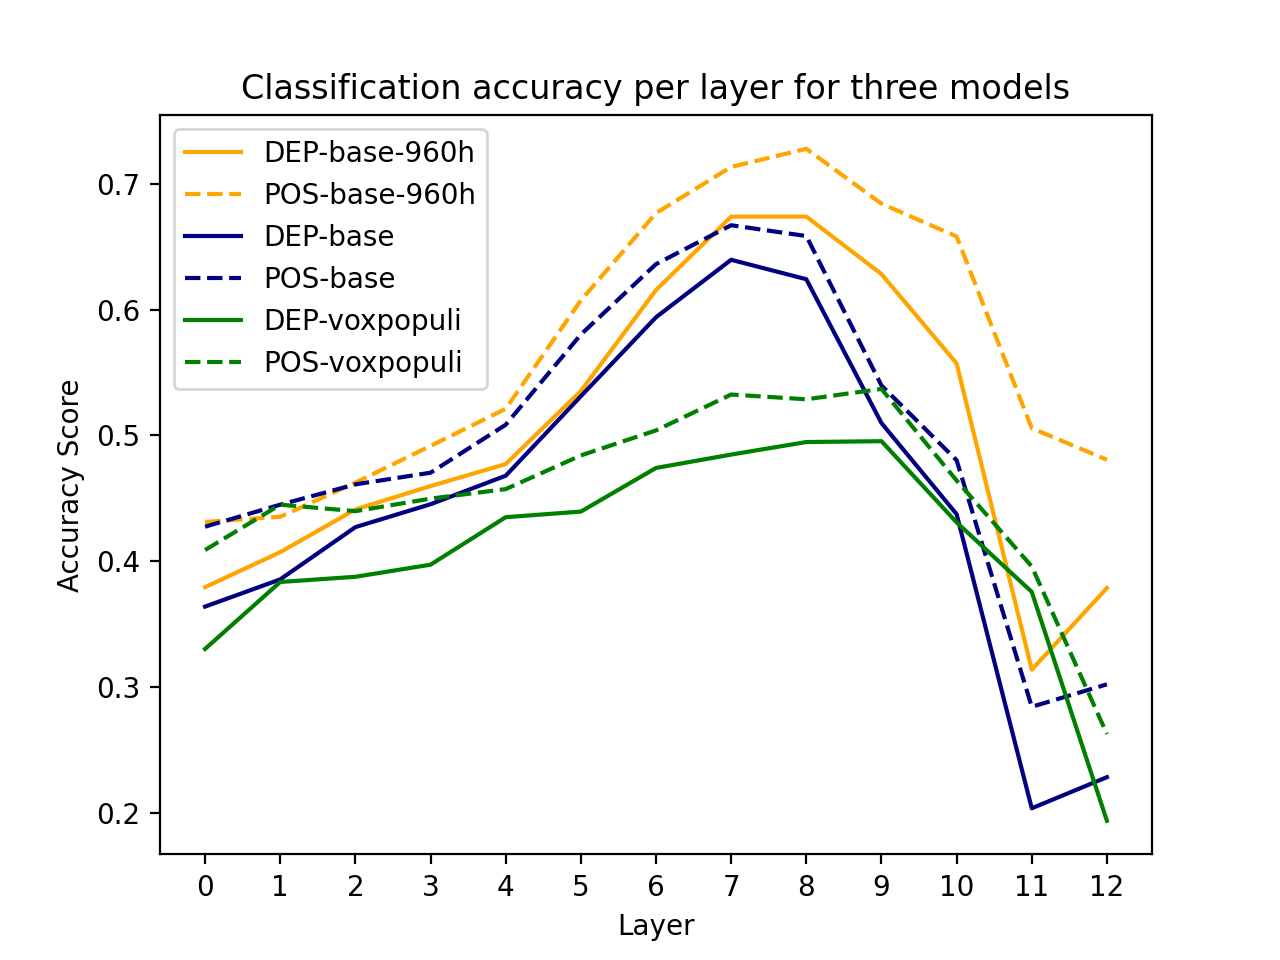

In [106]:
plt.plot(layers, acc_dep_mono, label = "DEP-base-960h", color = "orange")
plt.plot(layers, acc_pos_mono, label = "POS-base-960h", color = "orange", ls = "dashed")
plt.plot(layers, acc_dep_mono_no, label = "DEP-base", color = "navy")
plt.plot(layers, acc_pos_mono_no, label = "POS-base", color = "navy", ls = "dashed")
plt.plot(layers, acc_dep_multi, label = "DEP-voxpopuli", color = "green")
plt.plot(layers, acc_pos_multi, label = "POS-voxpopuli", color = "green", ls = "dashed")
plt.xlabel("Layer")
plt.xticks(np.arange(0, 13, step=1))
plt.ylabel("Accuracy Score")
plt.legend()
plt.title("Classification accuracy per layer for three models")
plt.show()

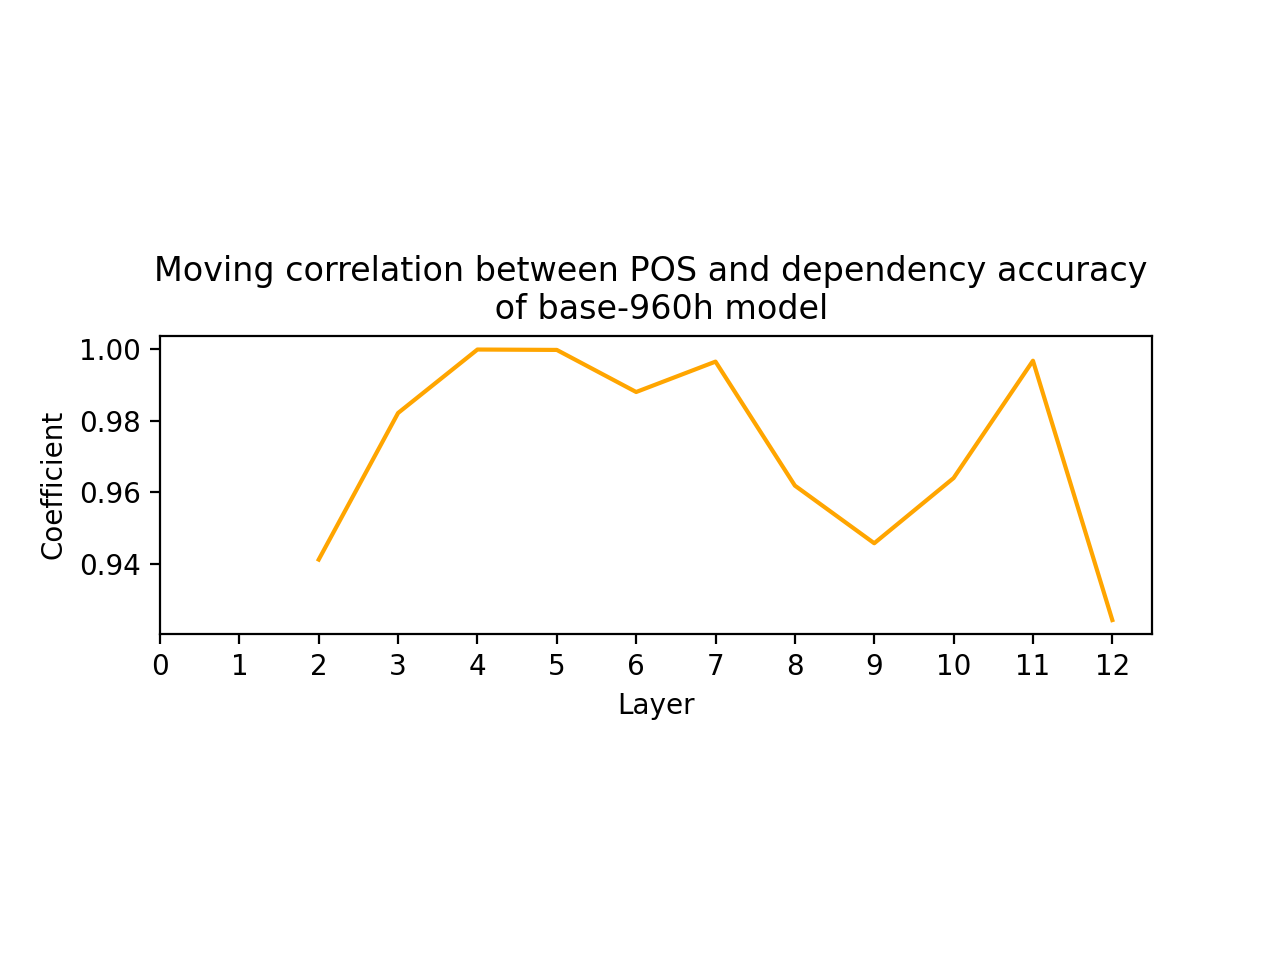

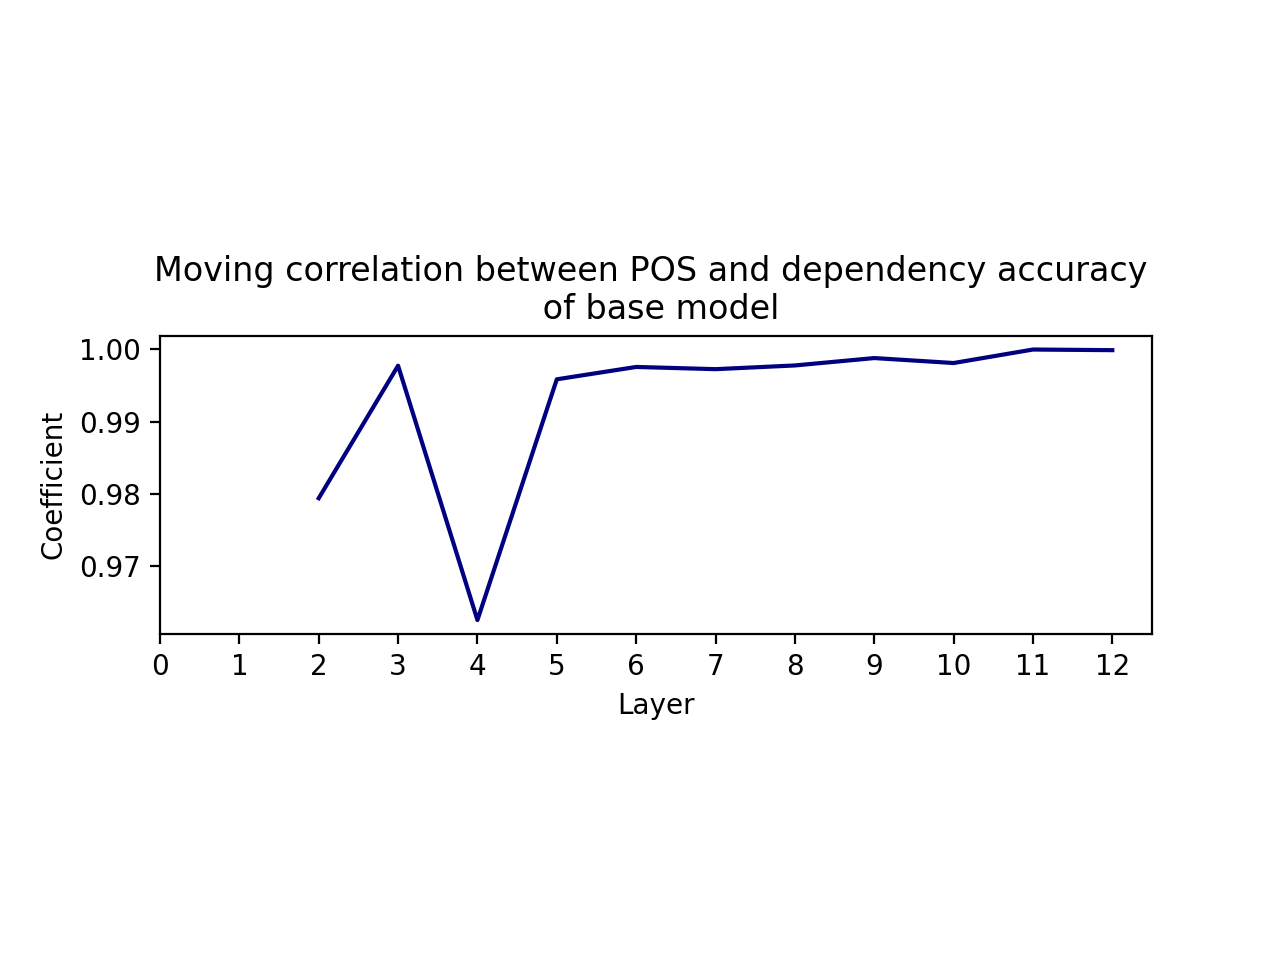

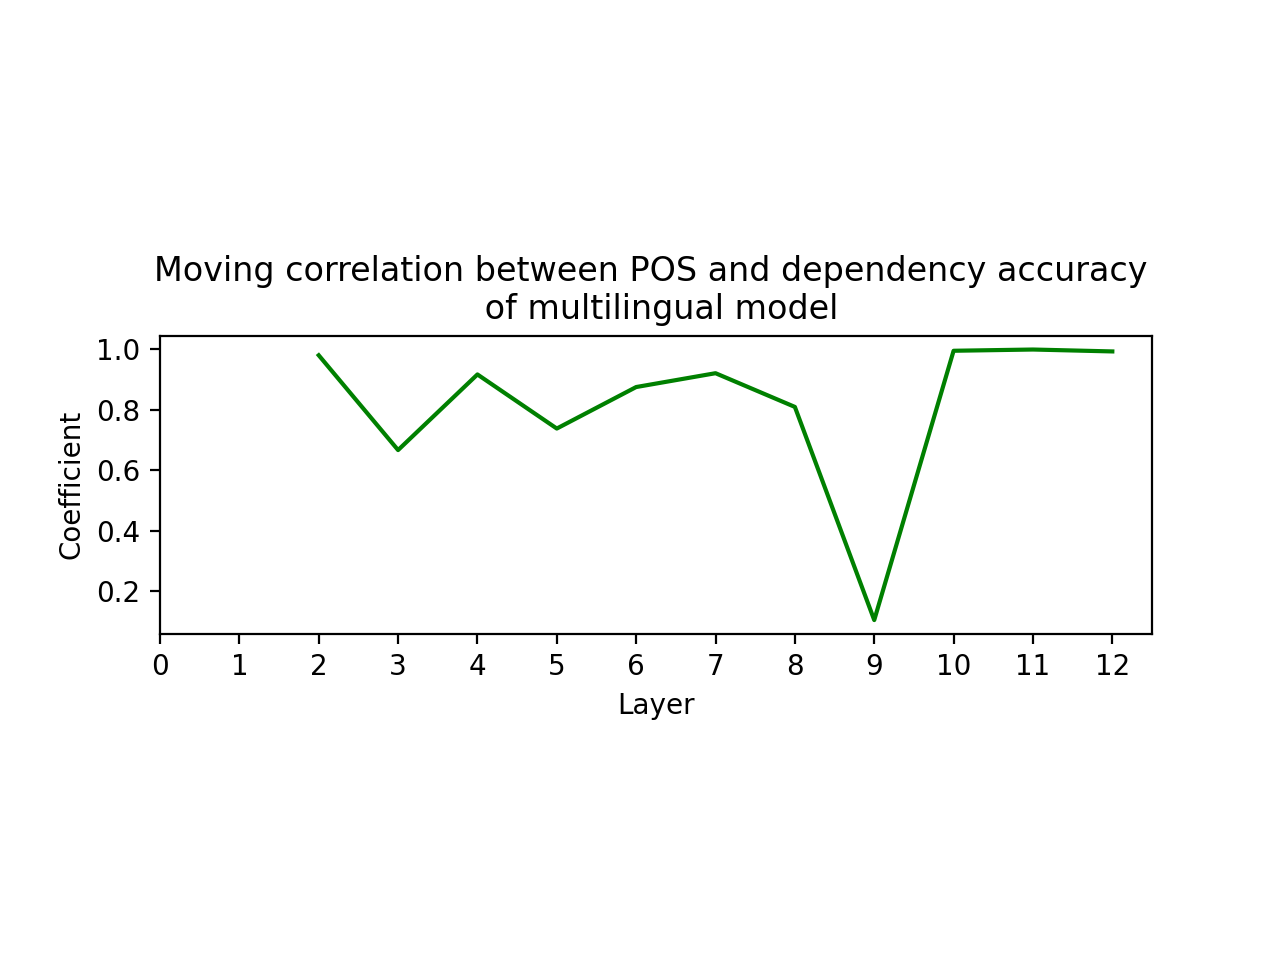

In [108]:
mono = pd.Series(acc_dep_mono).rolling(3).corr(pd.Series(acc_pos_mono))
plt.axes().set_box_aspect(0.3)
plt.plot(layers, mono, label = "Mono-960h", color = "orange")
plt.xlabel("Layer")
plt.xticks(np.arange(0, 13, step=1))
plt.ylabel("Coefficient")
plt.title("Moving correlation between POS and dependency accuracy \n of base-960h model")
plt.show()

mono_no = pd.Series(acc_dep_mono_no).rolling(3).corr(pd.Series(acc_pos_mono_no))
plt.axes().set_box_aspect(0.3)
plt.plot(layers, mono_no, label = "Mono", color = "navy")
plt.xlabel("Layer")
plt.xticks(np.arange(0, 13, step=1))
plt.ylabel("Coefficient")
plt.title("Moving correlation between POS and dependency accuracy \n of base model")
plt.show()

multi = pd.Series(acc_dep_multi).rolling(3).corr(pd.Series(acc_pos_multi))
plt.axes().set_box_aspect(0.3)
plt.plot(layers, multi, label = "Multi", color = "green")
plt.xlabel("Layer")
plt.xticks(np.arange(0, 13, step=1))
plt.ylabel("Coefficient")
plt.title("Moving correlation between POS and dependency accuracy \n of multilingual model")
plt.show()